<img src=".\img\mioti.png">   
<br />
<center style="color:#888">Proyecto Activaciones Madrid SAMUR-PC<br/></center>

# Proyecto Activaciones Madrid SAMUR-PC: Clasificación

<img src="./img/samur690.jpg" style="width: 800px">

# 1. Visión general del problema.

Nuestro objetivo es lograr clasificar las emergencias en función de su porcentaje de hospitalización, para conocer cuáles son más propensas a terminar en ingresos y realizar comparaciones entre ellas. Esto lo vamos a conseguir a través de las diferentes medidas de las que disponemos sobre activaciones de emergencias, realizando el tratamiento adecuado de estos datos

In [1]:
# instalar requisitos
# import sys
# !{sys.executable} -m pip install pandas numpy nltk wordcloud

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import Normalizer
from sklearn.cluster import AgglomerativeClustering
from wordcloud import WordCloud
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

## 2.Obtención de los datos

Una vez importadas las librerías necesarias para el análisis, procedemos a la importación del fichero preprocesado. Para llevar a cabo nuestro objetivo, será necesario realizar otro preprocesamiento adicional

In [3]:
#Se importa el archivo y se realiza una visualización del contenido de sus datos

emergencias_df=pd.read_csv('datos/emergencias_pp_def.csv',sep=';', encoding='iso8859')
emergencias_df.head()

,Fecha Activacion,Hora Solicitud,Hora Intervención,Código,Distrito,Hospital
0,2017-01-01,0:23:19,0:28:59,Heridas,Centro,Concepción (Fund. J. Díaz)
1,2017-01-01,0:27:35,0:35:44,Agresión sin especificar,Carabanchel,Sin hospitalizacion
2,2017-01-01,0:47:26,0:55:49,Intoxicación etílica,Salamanca,Sin hospitalizacion
3,2017-01-01,0:55:13,1:02:23,Agresión sin especificar,Centro,Doce de Octubre
4,2017-01-01,1:07:11,1:19:44,Accidente menos de 3 victimas,Villa de Vallecas,Sin hospitalizacion


## 3. Analizar y preparar los datos para nuestro algoritmo

Para realizar nuestra clasificación vamos a necesitar las fechas de activación de cada emergencia para conocer el número total de llamadas a Samur, el código para saber el tipo y si tuvo o no hospitalización

En primer lugar vamos a quedarnos con las variables que necesitamos de nuestro dataframe, después pasaremos a realizar las transformaciones necesarias hasta adaptar nuestro dataset al formato que nos proporcionará la clasificación que estamos buscando

In [4]:
#Se transforman las variables de fecha y hora a datetime y se revisa la información del dataframe

emergencias=emergencias_df[['Fecha Activacion','Código','Hospital']].copy()
emergencias['Fecha Activacion']=pd.to_datetime(emergencias['Fecha Activacion'])
emergencias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556526 entries, 0 to 556525
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Fecha Activacion  556526 non-null  datetime64[ns]
 1   Código            556374 non-null  object        
 2   Hospital          556526 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 12.7+ MB


In [5]:
#Se visualiza el número de tipos de emergencias y sus etiquetas

print('cuenta tipo emergencia: ',len(emergencias['Código'].unique()))
print()
print('tipo de emergencia: ',emergencias['Código'].unique())

cuenta tipo emergencia:  95

tipo de emergencia:  ['Heridas' 'Agresión sin especificar' 'Intoxicación etílica'
 'Accidente menos de 3 victimas' 'Inconsciente sin filiar causa'
 'Casual: caída, etc' 'Apertura de puerta' 'Atropello'
 'Violencia de genero' 'Accidente de bicicleta' 'Patología respiratoria'
 'Patología digestiva' 'Precipitado' 'Certificación psiquiátrico' 'Otros'
 'Parada Cardiorespiratoria' 'Arma blanca' 'Patología psicosomática'
 'Accidente de motocicleta' 'Patología urológica'
 'Patología cardiovascular' 'Colaboración del FOXTROP en una actuación'
 'Atención psicológica a Familiares y allegados'
 'Convulsión y/o epilepsia' 'Diabético' 'Sobredosis'
 'Servicios especiales' 'Servicios de seguimiento de riesgos' 'Incendio'
 'Paciente en huelga de hambre' 'Preventivos' 'Patología neurológica'
 'Orden medica' 'Infarto o patología coronaria' 'Patología infecciosa'
 'Incendio con Victimas confirmadas'
 'Intoxicación por fármacos y/o productos tóxicos'
 'Accidente con 3 o más víc

## 4. Preparar los datos para el algoritmo de Machine Learning que vamos a utilizar

Disponemos de un total de 95 tipos de emergencias diferentes, el objetivo ahora es unirlas en función de la proporción de hospitalizaciones que acumule cada una sobre su total de activaciones

###  Variables Codificadas

La variable 'Hospital' que nos facilita la información sobre si la emergencia acabó en ingreso o no esta definida como tipo objeto. Para poder calcular el número total de hospitalizaciones vamos a pasar a codificar la variable mediante una función

In [6]:
#Creamos un nuevo dataframe con los campos que vamos a utilizar

emergencias_agrup=emergencias[['Código','Fecha Activacion','Hospital']]

#Se codifica la variable hospital

def cod_hosp(x):
    if x['Hospital']=='Sin hospitalizacion':
        x['Hospital']=0
    else:
        x['Hospital']=1
    return x

#Se aplica la función
emergencias_agrup=emergencias_agrup.apply(cod_hosp,axis=1)
emergencias_agrup.sample(15)

,Código,Fecha Activacion,Hospital
209701,Patología cardiovascular,2018-07-17,1
325288,Otros,2019-05-14,0
97357,Patología cardiovascular,2017-09-27,1
34734,Agresión con spray de defensa,2017-04-09,0
546960,Intoxicación etílica,2021-02-28,1
507885,Accidente de motocicleta,2020-10-17,0
350278,Infarto o patología coronaria,2019-07-09,1
204037,Heridas,2018-07-03,0
148116,Orden medica,2018-02-07,1
157516,Patología cardiovascular,2018-03-05,0


### Agrupación de variables

A continuación vamos a generar un nuevo dataframe donde agruparemos las emergencias, realizando una cuenta de las fechas de activación obtendremos el número total de activaciones de cada emergencia, sumando los valores del campo 'Hospital' codificado el número de veces que cada emergencia acabó en hospitalización

In [7]:
#Se agrupan las variables

emergencias_agrup=emergencias_agrup.groupby('Código').agg({'Fecha Activacion':'count','Hospital':'sum'}).reset_index()

#Se cambia el nombre de Fecha Activación para facilitar la comprensión del dataframe

emergencias_agrup=emergencias_agrup.rename(columns={'Fecha Activacion':'Nº Activaciones'})
emergencias_agrup

,Código,Nº Activaciones,Hospital
0,+ de 3 SVB y eq. Sanit.,582,30
1,1 SVB,7092,125
2,1 o + SVB y 1 o + SVA,493,18
3,1 o + SVB y 1 o + SVA y PMA,679,25
4,Acc. Trasp. Merc. Peligrosas,1,0
...,...,...,...
89,Servicios especiales,1774,12
90,Sobredosis,2909,1133
91,Todos los medios de SAMUR-PC,6,0
92,Violencia de genero,6010,839


### Estandarización de variables

Para hacer el entrenamiento de nuestros modelos más sencillos, estandarizaremos las variables normalizándolas

In [8]:
#Se normalizan los datos

data=emergencias_agrup[['Nº Activaciones','Hospital']]
emergencias_norm=Normalizer().fit_transform(data)

## 5. Seleccionar un modelo y entrenarlo.

Una vez procesados los datos vamos a determinar el modelo que vamos a utilizar. En este caso hemos optado por un clustering jerárquico


### Cálculo del número óptimo de clusters

Ahora toca determinar cuál es el número óptimo de clusters en los que vamos a agrupar las emergencias, para ello vamos a utilizar un dendrograma. Una ver visualizado, un corte sobre la línea más larga generada entre las uniones de clusters nos indicará el mejor número de grupos a generar

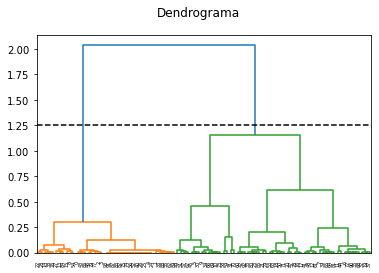

In [9]:
#Se realiza el dendrograma para determinar el número óptimo de clusters

dendrograma=sch.dendrogram(sch.linkage(emergencias_norm,method='ward'))
plt.suptitle('Dendrograma')
plt.axhline(y=1.25,xmin=0,xmax=100, color='k', linestyle='--');

Visualizando el dendrograma vemos que lo más óptimo es dividir el número de emergencias en dos grupos. A continuación pasaremos a realizar la clusterización, después veremos qué códigos forman parte de cada grupo

### Aplicamos el algoritmo

Una vez determinado el número óptimo del clusters vamos a pasar a definir y entrenar el modelo, después realizaremos una visualización de los resultados obtenidos

In [10]:
algoritmo = AgglomerativeClustering(n_clusters = 2, affinity='euclidean', linkage='ward')
#Se entrena el algoritmo
algoritmo.fit(emergencias_norm)
pred1 = algoritmo.fit_predict(emergencias_norm)
pred1=pd.Series(pred1)
emergencias_agrup1=pd.concat([emergencias_agrup,pred1],axis=1).rename(columns={0:'cluster'})
emergencias_agrup1=emergencias_agrup1.set_index('Código')
emergencias_agrup1

,Nº Activaciones,Hospital,cluster
Código,,,
+ de 3 SVB y eq. Sanit.,582,30,1
1 SVB,7092,125,1
1 o + SVB y 1 o + SVA,493,18,1
1 o + SVB y 1 o + SVA y PMA,679,25,1
Acc. Trasp. Merc. Peligrosas,1,0,1
...,...,...,...
Servicios especiales,1774,12,1
Sobredosis,2909,1133,0
Todos los medios de SAMUR-PC,6,0,1


In [11]:
#Se imprimen las listas de los códigos de cada grupo

cluster_0=emergencias_agrup1[emergencias_agrup1['cluster']==0].index
print('Emergencias cluster 1')
print()
print(cluster_0)
print()
cluster_1=emergencias_agrup1[emergencias_agrup1['cluster']==1].index
print('Emergencias cluster 2')
print()
print(cluster_1)
print()

Emergencias cluster 1

Index(['Accidente con 3 o más víctimas confirmadas',
       'Accidente con vehículo pesado', 'Accidente de autobús / autocar',
       'Accidente de bicicleta', 'Accidente de monopatin',
       'Accidente de motocicleta', 'Accidente menos de 3 victimas',
       'Agresión sin especificar', 'Ahogado', 'Apertura de puerta',
       'Arma blanca', 'Arma de fuego', 'Arrollamiento metro y/o tren',
       'Atención psicológica a Implicados.', 'Atrapamientos/enterramientos',
       'Atropello', 'Autolisis no traumática', 'Autolisis traumática',
       'Bombero de Madrid', 'Casual: caída, etc', 'Certificación psiquiátrico',
       'Convulsión y/o epilepsia', 'Diabético', 'Electrocutado', 'Explosión',
       'Heridas', 'Heridas complicadas', 'Incendio con Victimas confirmadas',
       'Inconsciente sin filiar causa', 'Infarto o patología coronaria',
       'Intoxicación etílica',
       'Intoxicación por fármacos y/o productos tóxicos',
       'Maltrato a ancianos', 'Orden j

## 6. Análisis de resultados

Nuestro modelo a agrupado las emergencias en dos grupos, ahora nos interesa conocer qué tipos se encuentran en cada uno de ellos, si alguno destaca más que el resto y cuáles son sus porcentajes de hospitalización


### Procesamiento de texto

Anteriormente imprimimos las listas con las emergencias que forman cada cluster, ahora queremos determinar cuáles son las más frecuentes en cada grupo, para ello vamos a trabajar con estas listas. Los pasos a seguir serán los siguientes

#### Limpieza de texto

En primer lugar vamos a filtrar los textos eliminando símbolos de puntuación, números y palabras como artículos o determinantes que no aportan información

In [12]:
def tokenizar(cluster):
    cluster_token = ''
    cluster_token=word_tokenize(cluster)
    return cluster_token

In [13]:
cluster_1_token = []
for t in cluster_0:
    cluster_1_token.extend(tokenizar(t))
print(cluster_1_token)

['Accidente', 'con', '3', 'o', 'más', 'víctimas', 'confirmadas', 'Accidente', 'con', 'vehículo', 'pesado', 'Accidente', 'de', 'autobús', '/', 'autocar', 'Accidente', 'de', 'bicicleta', 'Accidente', 'de', 'monopatin', 'Accidente', 'de', 'motocicleta', 'Accidente', 'menos', 'de', '3', 'victimas', 'Agresión', 'sin', 'especificar', 'Ahogado', 'Apertura', 'de', 'puerta', 'Arma', 'blanca', 'Arma', 'de', 'fuego', 'Arrollamiento', 'metro', 'y/o', 'tren', 'Atención', 'psicológica', 'a', 'Implicados', '.', 'Atrapamientos/enterramientos', 'Atropello', 'Autolisis', 'no', 'traumática', 'Autolisis', 'traumática', 'Bombero', 'de', 'Madrid', 'Casual', ':', 'caída', ',', 'etc', 'Certificación', 'psiquiátrico', 'Convulsión', 'y/o', 'epilepsia', 'Diabético', 'Electrocutado', 'Explosión', 'Heridas', 'Heridas', 'complicadas', 'Incendio', 'con', 'Victimas', 'confirmadas', 'Inconsciente', 'sin', 'filiar', 'causa', 'Infarto', 'o', 'patología', 'coronaria', 'Intoxicación', 'etílica', 'Intoxicación', 'por', 'fá

In [14]:
cluster_2_token = []
for t in cluster_1:
    cluster_2_token.extend(tokenizar(t))
print(cluster_2_token)

['+', 'de', '3', 'SVB', 'y', 'eq', '.', 'Sanit', '.', '1', 'SVB', '1', 'o', '+', 'SVB', 'y', '1', 'o', '+', 'SVA', '1', 'o', '+', 'SVB', 'y', '1', 'o', '+', 'SVA', 'y', 'PMA', 'Acc', '.', 'Trasp', '.', 'Merc', '.', 'Peligrosas', 'Accidente', 'de', 'avión', 'Accidente', 'sin', 'especificar', 'Agresión', 'con', 'spray', 'de', 'defensa', 'Agresión', 'sexual', 'Atención', 'psicológica', 'a', 'Familiares', 'y', 'allegados', 'Atención', 'psicológica', 'a', 'Testigos', '.', 'Atención', 'psicológica', 'a', 'intervinientes', 'de', 'Bomberos', '.', 'Atención', 'psicológica', 'a', 'intervinientes', 'de', 'Cuerpos', 'de', 'Seguridad', 'Atención', 'psicológica', 'a', 'intervinientes', 'de', 'SAMUR-PC', '.', 'Atención', 'psicológica', 'a', 'la', 'Víctima', 'primaria', 'Colaboración', 'del', 'FOXTROP', 'en', 'una', 'actuación', 'Derrumbamientos', 'Domicilio', 'Hasta', '3', 'SVB', 'Incendio', 'Local', 'público', '(', 'centro', 'sanita', '.', ')', 'Maltrato', 'a', 'menores', 'NO', 'APARECE', 'EN', 'COD

In [15]:
stopwords=stopwords.words('spanish')
def filtrar_cluster(palabras):
    out = []
    #Se crea una lista de palabras y signos no deseados
    eliminar=['.',',','¡','!','¿','?','""','(',')','=','/','+','#','$','&','*','-',';',':','_','{','}','[',']',"n't",
             "'s","'ve'",'...','-we','..','``','3','....','2',"'","'re",'iii',"'m",'<',"'d",'b','2.5','1','y','y/o']
    for word in palabras:
        if word in stopwords or word in eliminar:
            pass
        else:
            out.append(word)
    return out

In [16]:
cluster_1_filtrado = filtrar_cluster(cluster_1_token)
print(cluster_1_filtrado)

['Accidente', 'víctimas', 'confirmadas', 'Accidente', 'vehículo', 'pesado', 'Accidente', 'autobús', 'autocar', 'Accidente', 'bicicleta', 'Accidente', 'monopatin', 'Accidente', 'motocicleta', 'Accidente', 'menos', 'victimas', 'Agresión', 'especificar', 'Ahogado', 'Apertura', 'puerta', 'Arma', 'blanca', 'Arma', 'fuego', 'Arrollamiento', 'metro', 'tren', 'Atención', 'psicológica', 'Implicados', 'Atrapamientos/enterramientos', 'Atropello', 'Autolisis', 'traumática', 'Autolisis', 'traumática', 'Bombero', 'Madrid', 'Casual', 'caída', 'etc', 'Certificación', 'psiquiátrico', 'Convulsión', 'epilepsia', 'Diabético', 'Electrocutado', 'Explosión', 'Heridas', 'Heridas', 'complicadas', 'Incendio', 'Victimas', 'confirmadas', 'Inconsciente', 'filiar', 'causa', 'Infarto', 'patología', 'coronaria', 'Intoxicación', 'etílica', 'Intoxicación', 'fármacos', 'productos', 'tóxicos', 'Maltrato', 'ancianos', 'Orden', 'judicial', 'Orden', 'medica', 'Orden', 'médica', 'urgente', '/agresivo', 'Otras', 'institucione

In [17]:
cluster_2_filtrado = filtrar_cluster(cluster_2_token)
print(cluster_2_filtrado)

['SVB', 'eq', 'Sanit', 'SVB', 'SVB', 'SVA', 'SVB', 'SVA', 'PMA', 'Acc', 'Trasp', 'Merc', 'Peligrosas', 'Accidente', 'avión', 'Accidente', 'especificar', 'Agresión', 'spray', 'defensa', 'Agresión', 'sexual', 'Atención', 'psicológica', 'Familiares', 'allegados', 'Atención', 'psicológica', 'Testigos', 'Atención', 'psicológica', 'intervinientes', 'Bomberos', 'Atención', 'psicológica', 'intervinientes', 'Cuerpos', 'Seguridad', 'Atención', 'psicológica', 'intervinientes', 'SAMUR-PC', 'Atención', 'psicológica', 'Víctima', 'primaria', 'Colaboración', 'FOXTROP', 'actuación', 'Derrumbamientos', 'Domicilio', 'Hasta', 'SVB', 'Incendio', 'Local', 'público', 'centro', 'sanita', 'Maltrato', 'menores', 'NO', 'APARECE', 'EN', 'CODIGO', 'INICIAL', 'No', 'suceso', 'Paciente', 'huelga', 'hambre', 'Persona', 'techo', 'fallecida', 'vía', 'pública', 'Persona', '\x93sin', 'techo\x94', 'fallecida', 'vía', 'pública', 'Policía', 'municipal', 'Policía', 'nacional', 'Preventivos', 'Riesgo', 'biológico', 'Riesgo', 

### Resultados

Una vez filtradas las emergencias vamos a pasar a ver qué emergencias componen cada uno de los grupos

#### Visualización

Vamos a realizar una visualización mediante una nube de palabras

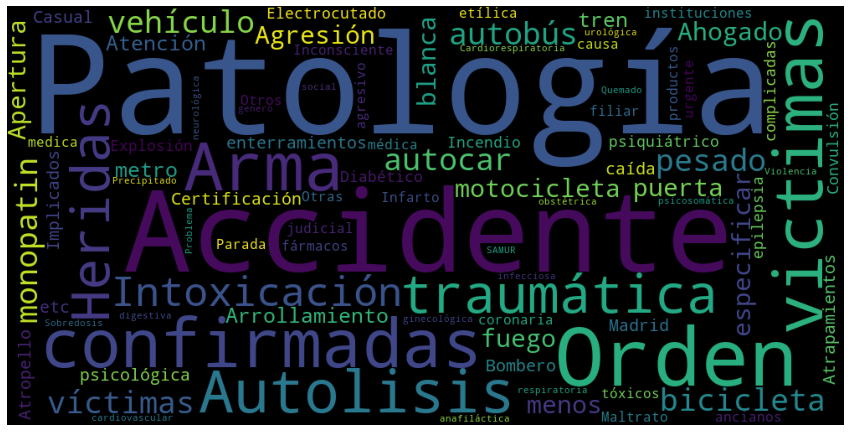

In [18]:
cluster_1_filtrado_join = ' '.join(cluster_1_filtrado)
wordcloud = WordCloud(width = 1000, height = 500, relative_scaling = 0.5).generate(cluster_1_filtrado_join)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

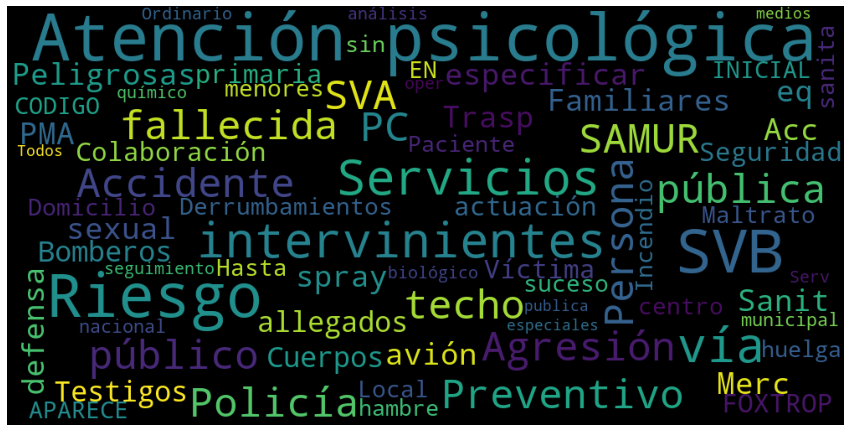

In [19]:
cluster_2_filtrado_join = ' '.join(cluster_2_filtrado)
wordcloud = WordCloud(width = 1000, height = 500, relative_scaling = 0.5).generate(cluster_2_filtrado_join)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Agrupaciones

En las visualizaciones podemos ver lo siguiente:

   * Cluster 1. Agrupa emergencias patológicas y accidentes
   
   * Cluster 2. La atención psicológica es la emergencia más notoria en este grupo
   
#### Tablas de resultados

Vamos a generar dataframes con cada uno de los cluster y visualizar su contenido

In [20]:
cluster_1_df=emergencias_agrup1[emergencias_agrup1['cluster']==0].sort_values('Nº Activaciones',ascending=False)
cluster_1_df['% hospital']=cluster_1_df['Hospital']/cluster_1_df['Nº Activaciones']
cluster_1_df

,Nº Activaciones,Hospital,cluster,% hospital
Código,,,,
"Casual: caída, etc",94733,45163,0,0.476740
Patología cardiovascular,91634,28205,0,0.307801
Intoxicación etílica,43584,8864,0,0.203377
Accidente menos de 3 victimas,28325,7910,0,0.279259
Agresión sin especificar,28126,7403,0,0.263208
Otros,26615,7560,0,0.284050
Heridas,24667,8597,0,0.348522
Accidente de motocicleta,21967,8035,0,0.365776
Patología psicosomática,18650,3783,0,0.202842


In [21]:
cluster_1_df.describe()

,Nº Activaciones,Hospital,cluster,% hospital
count,55.000000,55.000000,55.0,55.000000
mean,9182.127273,3161.418182,0.0,0.360654
std,18932.023482,7249.718648,0.0,0.166331
min,12.000000,2.000000,0.0,0.139601
25%,335.500000,63.500000,0.0,0.222672
50%,1869.000000,745.000000,0.0,0.330556
75%,8202.000000,3232.000000,0.0,0.466737
max,94733.000000,45163.000000,0.0,0.850987


In [22]:
cluster_2_df=emergencias_agrup1[emergencias_agrup1['cluster']==1].sort_values('Nº Activaciones',ascending=False)
cluster_2_df['% hospital']=cluster_2_df['Hospital']/cluster_2_df['Nº Activaciones']
cluster_2_df

,Nº Activaciones,Hospital,cluster,% hospital
Código,,,,
Incendio,15190,446,1,0.029361
Colaboración del FOXTROP en una actuación,8743,37,1,0.004232
1 SVB,7092,125,1,0.017625
Servicios de seguimiento de riesgos,3707,14,1,0.003777
Preventivos,2943,85,1,0.028882
Serv. Preventivo desde oper. Ordinario,2106,93,1,0.044160
Maltrato a menores,1793,199,1,0.110987
Servicios especiales,1774,12,1,0.006764
Hasta 3 SVB,1269,54,1,0.042553


In [23]:
cluster_2_df.describe()

,Nº Activaciones,Hospital,cluster,% hospital
count,39.000000,39.000000,39.0,39.000000
mean,1316.846154,38.256410,1.0,0.034457
std,2943.427733,80.362245,0.0,0.039268
min,1.000000,0.000000,1.0,0.000000
25%,10.500000,0.000000,1.0,0.000000
50%,152.000000,3.000000,1.0,0.017625
75%,1036.000000,36.500000,1.0,0.064131
max,15190.000000,446.000000,1.0,0.120818


#### Definición de cada cluster

Con los resultados obtenidos pasaremos aa definir cada cluster de la siguiente manera:

   * Cluster 1: Emergencias con alto grado de hospitalización compuestas mayormente por patologías y accidentes. Las clasificaremos como alta hospitalización
   
   * Cluster 2: Emergencias sin apenas hospitalizaciones con la atención psicológica como principal tipo. Las clasificaremos como baja hospitalizacion

#### Unión en dataframe original

Ahora pasaremos a añadir esta información al dataframe original

In [24]:
def union(x):
    emer=''
    if x['Código'] in cluster_0:
        emer='Ata hospitalizacion'
    elif x['Código'] in cluster_1:
        emer='Baja hospitalizacion'
    return emer

In [25]:
emergencias_cluster=emergencias_df.copy()
emergencias_cluster['cluster']=emergencias_cluster.apply(union,axis=1)
emergencias_cluster.sample(15)

,Fecha Activacion,Hora Solicitud,Hora Intervención,Código,Distrito,Hospital,cluster
95846,2017-09-23,15:20:18,15:30:03,Otros,Fuencarral - El Pardo,Sin hospitalizacion,Ata hospitalizacion
57491,2017-06-07,9:57:23,10:06:12,Colaboración del FOXTROP en una actuación,Villaverde,Sin hospitalizacion,Baja hospitalizacion
531383,2021-01-03,21:10:08,21:12:44,Patología cardiovascular,Chamberí,Sin hospitalizacion,Ata hospitalizacion
281720,2019-01-25,10:00:53,10:11:38,"Casual: caída, etc",Moratalaz,Gregorio Marañón,Ata hospitalizacion
412507,2019-12-15,5:14:58,5:31:44,Arma blanca,Villaverde,Doce de Octubre,Ata hospitalizacion
94719,2017-09-20,17:28:00,17:39:22,Patología respiratoria,Chamberí,Clínico San Carlos,Ata hospitalizacion
413834,2019-12-18,13:07:20,13:19:03,Convulsión y/o epilepsia,Latina,Gregorio Marañón,Ata hospitalizacion
90706,2017-09-09,3:46:15,3:53:59,Agresión sin especificar,Moratalaz,Sin hospitalizacion,Ata hospitalizacion
539793,2021-02-02,18:50:05,19:10:47,Otros,Tetuán,Sin hospitalizacion,Ata hospitalizacion
227497,2018-09-09,19:57:57,20:02:17,"Casual: caída, etc",San Blas - Canillejas,Sin hospitalizacion,Ata hospitalizacion


#### Representación gráfica

In [26]:
emergencias_g=emergencias_cluster.pivot_table(index='Distrito',columns='cluster',values='Código',aggfunc='count',margins=True)
emergencias_g['Alta']=emergencias_g['Ata hospitalizacion']/emergencias_g['All']
emergencias_g['Baja']=emergencias_g['Baja hospitalizacion']/emergencias_g['All']
emergencias_g=emergencias_g.drop('All',axis=0)
emergencias_g

cluster,,Ata hospitalizacion,Baja hospitalizacion,All,Alta,Baja
Distrito,,,,,,
Arganzuela,0.0,26637.0,2514.0,29151,0.913759,0.086241
Barajas,NaN,6712.0,1348.0,8060,0.832754,0.167246
Carabanchel,0.0,35517.0,2954.0,38471,0.923215,0.076785
Centro,0.0,73976.0,6516.0,80492,0.919048,0.080952
Chamartín,0.0,22195.0,2030.0,24225,0.916202,0.083798
Chamberí,0.0,24426.0,1700.0,26126,0.934931,0.065069
Ciudad Lineal,0.0,24498.0,1628.0,26126,0.937687,0.062313
Fuencarral - El Pardo,0.0,22565.0,3255.0,25820,0.873935,0.126065
Hortaleza,NaN,15633.0,1504.0,17137,0.912237,0.087763


In [27]:
em_g=emergencias_cluster.groupby('cluster').agg({'Código':'count'})
em_g=np.round(em_g['Código']/em_g['Código'].sum(),2)
em_g=em_g.drop('',axis=0)
em_g

cluster
Ata hospitalizacion     0.91
Baja hospitalizacion    0.09
Name: Código, dtype: float64

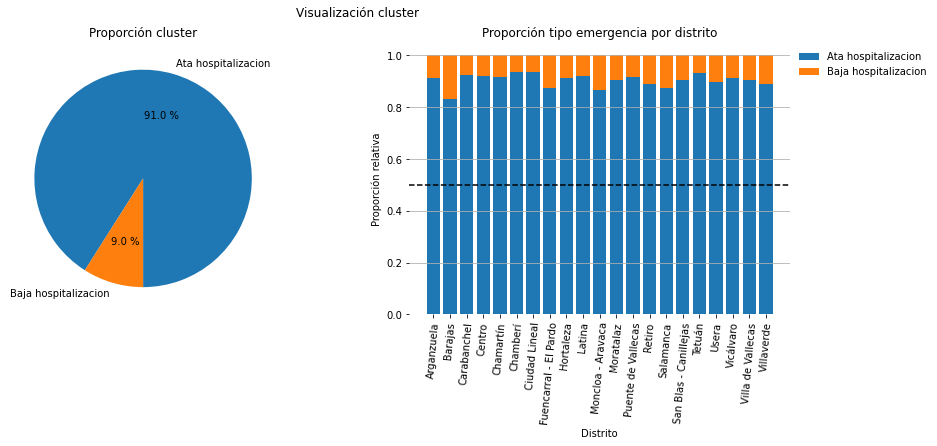

In [28]:
distrito=emergencias_g.index
emer=['Ata hospitalizacion','Baja hospitalizacion']
fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].pie(em_g,labels=emer,autopct="%0.1f %%",startangle=270)
ax[0].set_title('Proporción cluster')
ax[1].bar(emergencias_g.index,emergencias_g['Alta'],label='Ata hospitalizacion')
ax[1].bar(emergencias_g.index,emergencias_g['Baja'],bottom=emergencias_g['Alta'],label='Baja hospitalizacion')
plt.axhline(y=0.5, color='k', linestyle='--')
ax[1].set_ylabel('Proporción relativa')
ax[1].set_xlabel('Distrito')
ax[1].set_title('Proporción tipo emergencia por distrito')
fig.suptitle('Visualización cluster')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].set_xticks(distrito)
ax[1].set_xticklabels(distrito,rotation=85)
ax[1].grid(True, axis='y')
ax[1].legend(bbox_to_anchor=(1, 1),frameon=False);

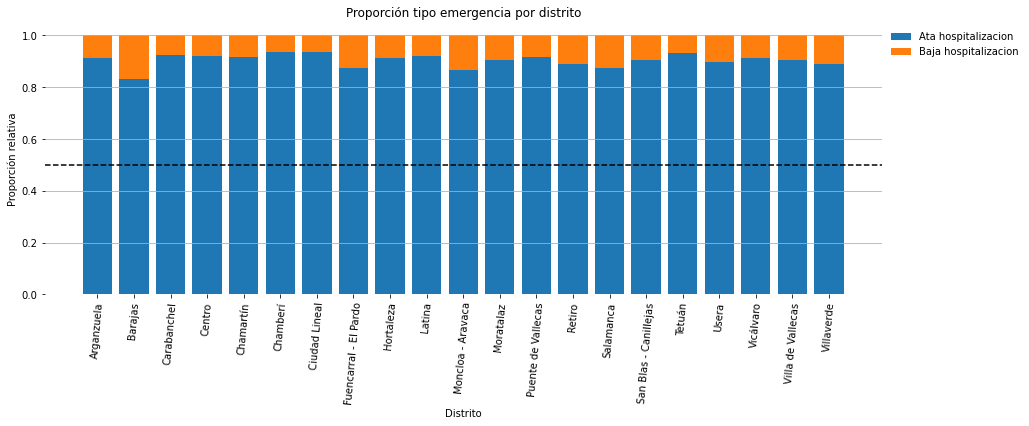

In [29]:
distrito=emergencias_g.index
emer=['Ata hospitalizacion','Baja hospitalizacion']
fig,ax=plt.subplots(figsize=(15,5))

ax.bar(emergencias_g.index,emergencias_g['Alta'],label='Ata hospitalizacion')
ax.bar(emergencias_g.index,emergencias_g['Baja'],bottom=emergencias_g['Alta'],label='Baja hospitalizacion')
plt.axhline(y=0.5, color='k', linestyle='--')
ax.set_ylabel('Proporción relativa')
ax.set_xlabel('Distrito')
ax.set_title('Proporción tipo emergencia por distrito')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks(distrito)
ax.set_xticklabels(distrito,rotation=85)
ax.grid(True, axis='y')
ax.legend(bbox_to_anchor=(1, 1),frameon=False);

## 7. Conclusiones

* Realizada la clasificación de emergencias y visualizando los resultados podemos concluir que existen dos tipos de emergencias en función de sus hospitalizaciones. Las emergencias que acumulan hospitalizaciones altas se centran sobre todo en patologías y accidentes mientras que las hospitalizaciones bajas en atención psicológica y servicios básicos


* Con esta clasificación en función de la activación de la emergencia el servicio SAMUR podría establecer tiempos de prioridad en sus respuestas o ponerse en contacto con los hospitales para advertir que es probable un nuevo ingreso


* Esta clasificación también nos puede servir para hacer comparativas entre diferentes emergencias, por ejemplo podemos ver que los accidentes de patinete y bicicleta tienen un porcentaje similar de hospitalización al de las patologías cardiovasculares y con ello, que autoridades diferentes a SAMUR elaboren planes para reducir este tipo de incidentes como, por ejemplo habilitando más carriles bici